### Import dependencies

In [1]:
import warnings
import torch
import lightning as L
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from utils.general import (get_bbox_from_config,
                           load_config, compute_mean_std,
                           create_gif_from_images,
                           save_best_model_as_pt,
                           save_config_to_log_dir)
from data.loaders import load_data
from data.datasets import CreateDataset
import xarray as xr

import torch
import torch.nn.functional as F
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
import numpy as np

In [2]:
# Load configuration and set seed
config = load_config()

In [3]:
hr_data = xr.open_dataset(
    config["dataset"]["hr_zarr_url"],
    engine="zarr", storage_options={"client_kwargs": {"trust_env": "true"}},
    chunks={})

lr_data = xr.open_dataset(
    config["dataset"]["lr_zarr_url"],
    engine="zarr", storage_options={"client_kwargs": {"trust_env": "true"}},
    chunks={})

In [4]:

latitude_range = tuple(config["dataset"]["latitude_range"])
longitude_range = tuple(config["dataset"]["longitude_range"])
hr = hr_data.sel(latitude=slice(latitude_range[0],latitude_range[1]),
                    longitude=slice(longitude_range[0],longitude_range[1]))
latitude_range = tuple(config["dataset"]["latitude_range"])
longitude_range = tuple(config["dataset"]["longitude_range"])
lr = lr_data.sel(latitude=slice(latitude_range[0],latitude_range[1]),
                    longitude=slice(longitude_range[0],longitude_range[1]))

In [5]:

start_date = config["dataset"]["start_date"]
end_date = config["dataset"]["end_date"]

hr = hr.sel(time=slice(start_date, end_date))
lr = lr.sel(time=slice(start_date, end_date))

In [6]:
hr

<xarray.Dataset> Size: 79GB
Dimensions:           (time: 8808, latitude: 256, longitude: 256)
Coordinates:
    entireAtmosphere  float64 8B ...
  * latitude          (latitude) float64 2kB 47.01 47.05 47.1 ... 58.18 58.22
  * longitude         (longitude) float64 2kB 5.01 5.054 5.098 ... 16.17 16.22
    step              timedelta64[ns] 8B ...
    surface           float64 8B ...
  * time              (time) datetime64[ns] 70kB 2020-01-01 ... 2021-01-01T23...
Data variables: (12/34)
    blh               (time, latitude, longitude) float32 2GB dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
    chnk              (time, latitude, longitude) float32 2GB dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
    d2m               (time, latitude, longitude) float32 2GB dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
    e                 (time, latitude, longitude) float32 2GB dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
    ewss              (time, latitude, longitude) float32 2GB dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
    hcc               (time, latitude, longitude) float32 2GB dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
    ...                ...
    tp                (time, latitude, longitude) float32 2GB dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
    tprate            (time, latitude, longitude) float32 2GB dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
    tsr               (time, latitude, longitude) float32 2GB dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
    ttr               (time, latitude, longitude) float32 2GB dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
    u10               (time, latitude, longitude) float32 2GB dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
    v10               (time, latitude, longitude) float32 2GB dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-11-14T08:10 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [7]:
import random

index = random.randint(0, lr.dims['time'])

/tmp/ipykernel_500434/1970391284.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  index = random.randint(0, lr.dims['time'])


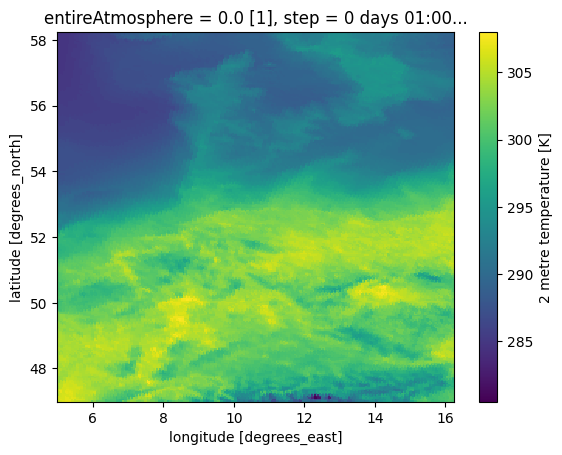

In [12]:
hr["t2m"][index].load().plot()

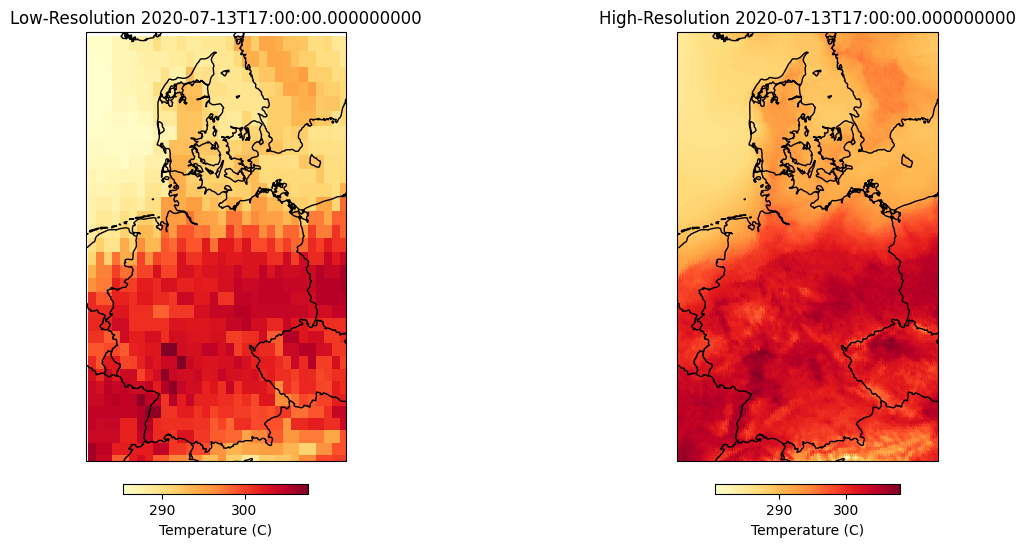

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

# Define the bounding box for the plot
bbox = [longitude_range[0], longitude_range[1], latitude_range[0], latitude_range[1]]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': ccrs.Mercator()})

# Load and plot low-resolution data
lr_image = lr["t2m"][index].load()
lr_plot = lr_image.plot(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    cmap="YlOrRd",
    vmin=lr_image.min(),
    vmax=lr_image.max(),
    add_colorbar=False
)
axes[0].coastlines()
axes[0].add_feature(cf.BORDERS)
axes[0].set_extent(bbox, crs=ccrs.PlateCarree())
axes[0].set_title(f"Low-Resolution {str(lr.time[index].values)}")

# Add colorbar for low-resolution plot
cbar_lr = fig.colorbar(lr_plot, ax=axes[0], orientation='horizontal', fraction=0.02, pad=0.05)
cbar_lr.set_label("Temperature (C)")

# Load and plot high-resolution data
hr_image = hr["t2m"][index].load()
hr_plot = hr_image.plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    cmap="YlOrRd",
    vmin=hr_image.min(),
    vmax=hr_image.max(),
    add_colorbar=False
)
axes[1].coastlines()
axes[1].add_feature(cf.BORDERS)
axes[1].set_extent(bbox, crs=ccrs.PlateCarree())
axes[1].set_title(f"High-Resolution {str(hr.time[index].values)}")

# Add colorbar for high-resolution plot
cbar_hr = fig.colorbar(hr_plot, ax=axes[1], orientation='horizontal', fraction=0.02, pad=0.05)
cbar_hr.set_label("Temperature (C)")

# Display the plot
plt.show()


In [28]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

def compute_psnr(hr_data, lr_upscaled):
    """
    Compute the Peak Signal-to-Noise Ratio (PSNR) between HR and upscaled LR data.

    Args:
        hr_data (torch.Tensor): High-resolution image.
        lr_upscaled (torch.Tensor): Low-resolution image upscaled to HR shape.

    Returns:
        float: PSNR value.
    """
    mse = F.mse_loss(hr_data, lr_upscaled)  # Mean Squared Error (MSE)
    if mse == 0:
        return float('inf')  # If MSE is zero, PSNR is infinite

    max_pixel = torch.max(hr_data)  # Max possible pixel value
    psnr = 10 * torch.log10((max_pixel ** 2) / mse)  # PSNR formula
    return psnr.item()

def compute_ssim(hr_data, lr_upscaled):
    """
    Compute the Structural Similarity Index Measure (SSIM) between HR and upscaled LR data.

    Args:
        hr_data (torch.Tensor): High-resolution image.
        lr_upscaled (torch.Tensor): Low-resolution image upscaled to HR shape.

    Returns:
        float: SSIM value.
    """
    ssim_index = StructuralSimilarityIndexMeasure().to(device)
    ssim_value = ssim_index(hr_data.unsqueeze(0).unsqueeze(0), lr_upscaled.unsqueeze(0).unsqueeze(0))
    return ssim_value.item()

# Store PSNR and SSIM values
psnr_values = []
ssim_values = []

# Iterate over all time steps
for t in range(hr["t2m"].shape[0]):
    hr_data = torch.tensor(hr["t2m"][t].load().values, dtype=torch.float32).to(device)  # Extract HR data at time t
    lr_data = torch.tensor(lr["t2m"][t].load().values, dtype=torch.float32).to(device)  # Extract LR data at time t

    # Resize LR data to match HR shape using bicubic interpolation
    lr_upscaled = F.interpolate(lr_data.unsqueeze(0).unsqueeze(0), size=(hr_data.shape[0], hr_data.shape[1]), mode='bilinear', align_corners=False).squeeze()

    # Compute PSNR and SSIM
    psnr_values.append(compute_psnr(hr_data, lr_upscaled))
    ssim_values.append(compute_ssim(hr_data, lr_upscaled))

# Compute average PSNR and SSIM over all time steps
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)

std_psnr = np.std(psnr_values)
std_ssim = np.std(ssim_values)

print(f"Average PSNR over {len(psnr_values)} time steps: {average_psnr:.2f} dB ± {std_psnr:.2f}")
print(f"Average SSIM over {len(ssim_values)} time steps: {average_ssim:.4f} ± {std_ssim:.4f}")

In [ ]:

%%timeit
for t in range(hr["t2m"].shape[0]):

    lr_data = torch.tensor(lr["t2m"][t].compute().values, dtype=torch.float32).to(device)


44.2 s ± 1.06 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
for t in range(hr["t2m"].shape[0]):

    lr_data = torch.tensor(lr["t2m"][t].values, dtype=torch.float32).to(device)

48.4 ms ± 387 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
